In [33]:
import json
import glob
from GPTUtils import query, prompts
from openai import OpenAI
def save_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4, ensure_ascii=False)
# openai (temp)
openai_api_key = open("openai_api_key").read()
openai_client=OpenAI(api_key=openai_api_key, timeout=30)

In [20]:
# def identify_var_types(all_chunks, openai_client, system_prompt_blocks, user_prompt_blocks, prompt_variables):
#     identify_var_type_prompt_list = []
#     response_format, extract_response_func = None, None
#     for chunk in all_chunks:
#         conversation = chunk['conversation']
#         prompt_variables['conversation'] = conversation_to_string(conversation)
#         identify_var_type_prompt, response_format, extract_response_func = prompts.identify_var_type_prompt_factory(system_prompt_blocks, user_prompt_blocks, prompt_variables)
#         identify_var_type_prompt_list.append(identify_var_type_prompt)
#     identified_var_types = query.multithread_prompts(openai_client, identify_var_type_prompt_list, response_format=response_format, temperature=0.0)
#     if response_format == 'json':
#         identified_var_types = [extract_response_func(i) for i in identified_var_types]
#     for (chunk_index, var_types) in enumerate(identified_var_types):
#         chunk = all_chunks[chunk_index]
#         chunk['var_types'] = var_types
#     return all_chunks

In [21]:
# var_type_definitions = {
#     "driver": "fundamental human causes that lead to certain impacts on the environment to meet basic human needs.",
#     "pressure": "negative phenomena or activities affecting the environment or ecosystems, which are caused by drivers or occur naturally.",
#     "state": "the quantity and quality of physical, chemical, and biological phenomena within a specific timeframe and area.",
#     "impact": "adverse changes in environmental conditions, ecosystem functions, or human well-being.",
#     "response": "any behavior, action, or effort to protect the environment, address environmental issues, or be environmentally friendly."
# }
# for variable_definition_file in glob.glob("contexts/variable_definitions/*.json"):
#     variable_definitions = json.load(open(variable_definition_file))

In [22]:
# prompt_variables = {
#     "var_types": "\n".join([f"{var_type}: {var_type_def}" for var_type, var_type_def in var_type_definitions.items()]),
# }
# prompts = json.load(open('prompts/identify_var_types.json'))
# system_prompt_blocks = prompts['system_prompt_blocks']
# user_prompt_blocks = prompts['user_prompt_blocks']
# all_chunks = []
# for chunk_file in glob.glob("data/v2/tmp/chunk/chunk_summaries_w_ktte/*.json"):
#     chunks = json.load(open(chunk_file))
#     all_chunks += chunks
# # identify the variables in three prompts:
# # First, identify if there are any mentions about the var types by extracting the sentences that mention the var types
# # all_chunks = all_chunks[:1] # test run
# system_prompt_blocks = [prompt_block[1] for prompt_block in system_prompt_blocks]
# user_prompt_blocks = [prompt_block[1] for prompt_block in user_prompt_blocks]
# all_chunks = identify_var_types(all_chunks, openai_client, system_prompt_blocks, user_prompt_blocks, prompt_variables)

# If so, identify the corresponding variables by assigning variables to the sentences
# If no existing variables can be matched, assign it to 'others'

In [23]:
all_chunks = []
for chunk_file in glob.glob("data/v2/tmp/chunk/chunk_summaries_w_ktte/*.json"):
    chunks = json.load(open(chunk_file))
    all_chunks += chunks
len(all_chunks)
save_json(all_chunks, "data/v2/tmp/pipeline/init/chunks.json")

FileNotFoundError: [Errno 2] No such file or directory: 'data/v2/tmp/pipeline/init/chunks.json'

In [ ]:
var_type_definitions = json.load(open('GPTUtils/contexts/var_type_definitions.json'))
prompts = json.load(open('GPTUtils/prompts/identify_var_types.json'))
system_prompt_blocks = prompts['system_prompt_blocks']
user_prompt_blocks = prompts['user_prompt_blocks']
prompt_variables = {
    "var_types": "\n".join([f"{var_type}: {var_type_def}" for var_type, var_type_def in var_type_definitions.items()]),
}
all_chunks = json.load(open("data/v2/tmp/pipeline/init/chunks.json"))
print(len(all_chunks))
# all_chunks = all_chunks[:10]
system_prompt_blocks = [prompt_block[1] for prompt_block in system_prompt_blocks]
user_prompt_blocks = [prompt_block[1] for prompt_block in user_prompt_blocks]
all_chunks = query.identify_var_types(all_chunks, openai_client, system_prompt_blocks, user_prompt_blocks, prompt_variables)
save_json(all_chunks, "data/v2/tmp/pipeline/identify_var_types/chunk_w_var_types.json")

598


100%|██████████| 598/598 [00:20<00:00, 28.84it/s]


In [ ]:
all_chunks = json.load(open("data/v2/tmp/pipeline/identify_var_types/chunk_w_var_types.json"))

for chunk in all_chunks:
    var_type_result = chunk['identify_var_types_result']
    var_type_result = list(filter(lambda x: x["var_type"] != 'none', var_type_result))
    chunk['identify_var_types_result'] = var_type_result

save_json(all_chunks, "data/v2/tmp/pipeline/identify_var_types/chunk_w_var_types_filtered.json")


In [ ]:
var_type_definitions = json.load(open('GPTUtils/contexts/var_type_definitions.json'))
var_definitions = {}
for var_type in var_type_definitions.keys():
    var_definitions_by_type = json.load(open(f"GPTUtils/contexts/variable_definitions/{var_type}_variables_def.json"))
    var_definitions[var_type] = var_definitions_by_type

prompts = json.load(open('GPTUtils/prompts/identify_vars.json'))
system_prompt_blocks = prompts['system_prompt_blocks']
user_prompt_blocks = prompts['user_prompt_blocks']
prompt_variables = {}
for var_type, var_type_def in var_type_definitions.items():
    prompt_variables[var_type] = {
        "definition": var_type_def,
        "vars": "\n".join([f"{var_name}: {var_def}" for var_name, var_def in var_definitions[var_type].items()])
    }
all_chunks = json.load(open("data/v2/tmp/pipeline/identify_var_types/chunk_w_var_types.json"))
# all_chunks = all_chunks[:10]
system_prompt_blocks = [prompt_block[1] for prompt_block in system_prompt_blocks]
user_prompt_blocks = [prompt_block[1] for prompt_block in user_prompt_blocks]
all_chunks = query.identify_vars(all_chunks, openai_client, system_prompt_blocks, user_prompt_blocks, prompt_variables)
save_json(all_chunks, "data/v2/tmp/pipeline/identify_vars/chunk_w_vars.json")

100%|██████████| 774/774 [00:36<00:00, 20.99it/s]


In [ ]:
all_chunks = json.load(open("data/v2/user/pipeline/init/chunks.json"))
all_chunks = all_chunks[:10]
chunk_conversations = [query.conversation_to_string(chunk['conversation']) for chunk in all_chunks]
chunk_embeddings = query.multithread_embeddings(openai_client, chunk_conversations)
res = []
for (chunk_index, chunk_embedding) in enumerate(chunk_embeddings):
    res.append({
        "id": all_chunks[chunk_index]['id'],
        "embedding": chunk_embedding
    })
save_json(res, "data/v2/user/pipeline/init/chunk_embeddings.json")

  0%|          | 0/10 [00:00<?, ?it/s]

tokens: tokens:  322 False
tokens:  255 False
 96 False
tokens:  468 False
tokens:  128 False
tokens:  404 False
tokens:  431 False
tokens:  284 False
tokens:  84 False
tokens:  267 False


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


In [ ]:
from pprint import pprint
def process_links(chunk_w_vars):
    links = []
    for chunk in chunk_w_vars:
        chunk_id = chunk['id']
        all_vars_in_chunk =  [(var_type, var_mention) for 
                              var_type, var_mentions in chunk['identify_vars_result'].items()
                              for var_mention in var_mentions]
        if len(all_vars_in_chunk) == 0: continue
        for i in range(len(all_vars_in_chunk)):
            for j in range(i+1, len(all_vars_in_chunk)):
                indicator1, var1 = all_vars_in_chunk[i]
                indicator2, var2 = all_vars_in_chunk[j]
                links.append({
                    "chunk_id": chunk_id,
                    "var1": var1['var'],
                    "var2": var2['var'],
                    "indicator1": indicator1,
                    "indicator2": indicator2,
                    "response": {
                        "relationship": "",
                        "evidence": ""
                    }
                })
    return links
chunk_w_vars = json.load(open("data/v2/user/pipeline/identify_vars/chunk_w_vars.json"))
links = process_links(chunk_w_vars)
links[1]

{'chunk_id': 'N6_3',
 'var1': '旅遊業',
 'var2': '人口',
 'indicator1': 'driver',
 'indicator2': 'driver',
 'response': {'relationship': '', 'evidence': ''}}

In [ ]:
all_chunks = json.load(open("data/v2/user/pipeline/identify_vars/chunk_w_vars.json"))
all_chunks = all_chunks[:10]
candidate_links = query.filter_candidate_links(all_chunks)
chunk_dict = {chunk['id']: dict(chunk, **{'identify_links_result':[]}) for chunk in all_chunks}
raw_variable_definitions = json.load(open('GPTUtils/contexts/variable_definitions.json'))
variable_definitions= {
    var_data['var_name']: var_data['definition']
    for var_list in raw_variable_definitions.values()
    for var_data in var_list
}

prompt_template = json.load(open('GPTUtils/prompts/identify_links.json'))
system_prompt_blocks = [prompt_block[1] for prompt_block in prompt_template['system_prompt_blocks']]
user_prompt_blocks = [prompt_block[1] for prompt_block in prompt_template['user_prompt_blocks']]
prompt_variables = {
    "links": candidate_links,
    "variable_definitions": variable_definitions,
}
prompt_list = []
chunk_id_list = []
link_metadata_list = []
print(len(candidate_links))
for link in candidate_links:
    if link['var1'] == '其他' or link['var2'] == '其他': continue
    conversation = chunk_dict[link['chunk_id']]['conversation']
    prompt_variables['conversation'] = query.conversation_to_string(conversation)
    prompt_variables['var1'] = f"{link['var1']}, {variable_definitions[link['var1']]}"
    prompt_variables['var2'] = f"{link['var2']}, {variable_definitions[link['var2']]}"
    prompt, response_format, extract_response_func = prompts.identify_link_prompt_factory(system_prompt_blocks, user_prompt_blocks, prompt_variables)
    prompt_list.append(prompt)
    chunk_id_list.append(link['chunk_id'])
    link_metadata_list.append(link) 
responses = query.multithread_prompts(openai_client, prompt_list, response_format=response_format, temperature=0.0)
if response_format == 'json':
    responses = [extract_response_func(i) for i in responses]
responses
for (response_index, extraction_result) in enumerate(responses):
    if extraction_result is None: continue
    chunk_id = chunk_id_list[response_index]
    chunk = chunk_dict[chunk_id]
    link_metadata = link_metadata_list[response_index]
    chunk["identify_links_result"].append({
        "chunk_id": link_metadata['chunk_id'],
        "var1": link_metadata['var1'],
        "var2": link_metadata['var2'],
        "indicator1": link_metadata['indicator1'],
        "indicator2": link_metadata['indicator2'],
        "response": extraction_result
    })
all_chunks = list(chunk_dict.values())
save_json(all_chunks, "data/v2/user/pipeline/identify_links/chunk_w_links.json") 

107


100%|██████████| 107/107 [00:41<00:00,  2.57it/s]


In [8]:
import json
chunks = json.load(open("data/v2/user/pipeline/identify_links/chunk_w_links.json"))
def check_evidences(results, max_index):
    for evidences in results:
        for evidence in evidences:
            if evidence >= max_index:
                return False
    return True
for chunk in chunks:
    # var_type_evidences = [var_type['evidence'] for var_type in chunk['identify_var_types_result']]
    # var_evidences = [var['evidence'] for var_list in chunk['identify_vars_result'].values() for var in var_list] 
    link_evidences = [link['response']['evidence'] for link in chunk['identify_links_result']]
    if not check_evidences(link_evidences, len(chunk['conversation'])):
        print(chunk['id'])

In [ ]:
def average_pairwise_jaccard(candidate_sets):
    from itertools import combinations
    total_jaccard_distance = 0
    pairs = list(combinations(candidate_sets, 2))
    for pair in pairs:
        set1, set2 = pair
        set1 = set(set1)
        set2 = set(set2)
        union = set1.union(set2)
        if len(union) == 0: continue
        intersection = set1.intersection(set2)
        jaccard_distance = (len(union) - len(intersection)) / len(union)
        total_jaccard_distance += jaccard_distance
    return total_jaccard_distance / len(pairs)



In [75]:
import json
def merge_var_types(var_type_results):
    merged_var_types = {}
    for var_types in var_type_results:
        for var_type in var_types:
            if var_type['var_type'] not in merged_var_types:
                merged_var_types[var_type['var_type']] = var_type
        else:
            merged_var_types[var_type['var_type']]['evidence'] = list(set(merged_var_types[var_type['var_type']]['evidence'] + var_type['evidence']))
    return list(merged_var_types.values())
# identify var types
iteration_results = []
k=5
for _ in range(k):
    all_chunks = json.load(open("data/v2/user/pipeline/identify_links/chunk_w_links.json"))
    for chunk_index, chunk in enumerate(all_chunks):
        if len(iteration_results) <= chunk_index: iteration_results.append([])
        iteration_results[chunk_index].append(chunk['identify_var_types_result'])
for chunk_index, chunk in enumerate(all_chunks):
    ensemble_var_types = merge_var_types(iteration_results[chunk_index])
    candidate_var_types = list(map(lambda var_types: [x['var_type'] for x in var_types], iteration_results[chunk_index]))
    uncertainty = average_pairwise_jaccard(candidate_var_types)
    for var_type_result in ensemble_var_types:
        var_type_occurrence = len(list(filter(lambda candidate: var_type_result['var_type'] in candidate, candidate_var_types)))
        confidence = var_type_occurrence / k
        var_type_result['uncertainty'] = uncertainty
        var_type_result['confidence'] = confidence
    chunk['identify_var_types_result'] = ensemble_var_types
    if 'uncertainty' not in chunk: chunk['uncertainty'] = {}
    chunk['uncertainty']['identify_var_types'] = uncertainty

[{'var_type': 'driver', 'evidence': [1, 2, 3, 4, 7], 'explanation': 'The interviewee discusses the fundamental human need for housing and the economic activities surrounding it, such as renting and utilizing vacant spaces. This indicates that the drivers of these issues are related to the basic human need for shelter and the economic motivations of the residents.', 'uncertainty': 0.0, 'confidence': 1.0}, {'var_type': 'pressure', 'evidence': [3, 4, 15, 18], 'explanation': 'The discussion includes pressures on the environment and local resources, such as the overdevelopment of land and the strain on public services like transportation and parking. These pressures are caused by the actions of residents and businesses in response to economic opportunities.', 'uncertainty': 0.0, 'confidence': 1.0}, {'var_type': 'state', 'evidence': [0, 1, 9, 10], 'explanation': "The interviewee describes the current state of the island's economy, housing situation, and community dynamics, indicating the qua

In [82]:
from collections import defaultdict
def merge_vars(vars_results):
    merged_vars = {}
    for vars in vars_results:
        for var in vars:
            if var['var'] not in merged_vars:
                merged_vars[var['var']] = var
            else:
                merged_vars[var['var']]['evidence'] = list(set(merged_vars[var['var']]['evidence'] + var['evidence']))
    return list(merged_vars.values())
# identify vars
iteration_results = []
k=5
for _ in range(k):
    # all_chunks = query.identify_vars(all_chunks, openai_client, system_prompt_blocks, user_prompt_blocks, prompt_variables)
    # all_chunks = json.load(open("data/v2/user/pipeline/identify_var_types/chunk_w_var_types.json"))
    all_chunks = json.load(open("data/v2/user/pipeline/identify_links/chunk_w_links.json"))
    for chunk_index, chunk in enumerate(all_chunks):
        if len(iteration_results) <= chunk_index: iteration_results.append(defaultdict(list))
        for var_type, vars in chunk['identify_vars_result'].items():
            # iteration_results[chunk_index][var_type].append(list(map(lambda x: x['var'], vars)))
            iteration_results[chunk_index][var_type].append(vars)
for chunk_index, chunk in enumerate(all_chunks[:3]):
    for var_type, vars in iteration_results[chunk_index].items():
        ensemble_vars = merge_vars(vars)
        candidate_vars = list(map(lambda var_list: [x['var'] for x in var_list], vars))
        vars_set = set([var for var_list in candidate_vars for var in var_list])
        uncertainty = average_pairwise_jaccard(candidate_vars)
        for var in vars_set:
            var_occurrence = len(list(filter(lambda candidate: var in candidate, candidate_vars)))
            confidence = var_occurrence / k
            var_index = list(map(lambda x: x['var'], ensemble_vars)).index(var)
            ensemble_vars[var_index]['confidence'] = confidence
            ensemble_vars[var_index]['uncertainty'] = uncertainty
            chunk['identify_vars_result'][var_type] = ensemble_vars
        if 'uncertainty' not in chunk: chunk['uncertainty'] = {}
        chunk['uncertainty']['identify_vars'] = uncertainty
print(all_chunks[2]['identify_vars_result'])

# save_json(all_chunks, "data/v2/user/pipeline/identify_vars/chunk_w_vars_w_uncertainty.json")

{'pressure': [{'var': '土地利用和土地覆蓋變化', 'evidence': [0, 1, 3], 'explanation': 'The interviewee discusses the contradictions of applying for water and electricity in a conservation area, which implies land use changes and development activities that are not in line with conservation efforts. This indicates pressure on the environment due to human activities.', 'confidence': 1.0, 'uncertainty': 0.0}]}


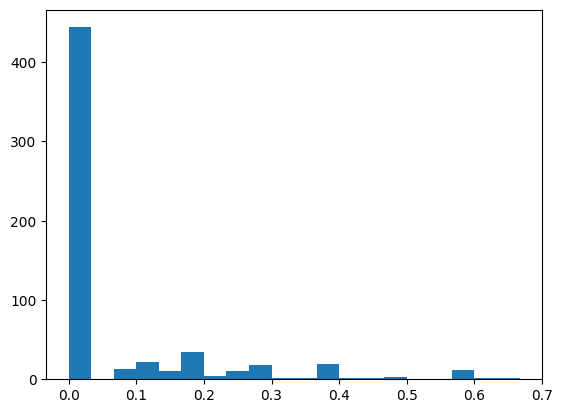

In [29]:
all_chunks = json.load(open("data/v2/user/pipeline/identify_var_types/chunk_w_var_types_w_uncertainty.json"))
uncertainties = [chunk['uncertainty_var_type'] for chunk in all_chunks]
# visualize the uncertainty using matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.hist(uncertainties, bins=20)
plt.show()
